# Lab 7: Dimensionality Reduction and Unsupervised Machine Learning

### imports

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import glob, json
import scipy.stats as stats
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.cluster import HDBSCAN, DBSCAN
from scipy.sparse import csc_matrix
from sklearn.preprocessing import StandardScaler

## Load the data

In [2]:
data = {}
issue_log = []
# load in json file data from email_json directory
# can use built in python json library to load in json data
for file in glob.glob('email_json/email_json/*'):
    with open(file) as f:
        f = f.read()
        email = json.loads(f)
        issue_log.append(email)
        for key in email:
            if key not in data:
                data[key] = []
            data[key].append(email[key])

In [3]:
# Convert the list of dicts into a Pandas DataFrame.
# The DataFrame should have 5 columns and 63,452 rows
df = pd.DataFrame.from_dict(data)
df.info()
print(df['category'].value_counts())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63542 entries, 0 to 63541
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   category      63542 non-null  object
 1   to_address    63141 non-null  object
 2   from_address  63542 non-null  object
 3   subject       63410 non-null  object
 4   body          63542 non-null  object
dtypes: object(5)
memory usage: 2.4+ MB
category
spam    40450
ham     23092
Name: count, dtype: int64


category                                  to_address  \
0         spam                   the00@speedy.uwaterloo.ca   
1          ham             debian-mirrors@lists.debian.org   
2         spam                    <the00@plg.uwaterloo.ca>   
3         spam                    opt4@speedy.uwaterloo.ca   
4         spam                ktwarwic@speedy.uwaterloo.ca   
...        ...                                         ...   
63537     spam  "Deficient" <deficient@flax9.uwaterloo.ca>   
63538     spam                 <smiles@flax9.uwaterloo.ca>   
63539     spam    "Gnitpick" <gnitpick@flax9.uwaterloo.ca>   
63540     spam    "Gnitpick" <gnitpick@flax9.uwaterloo.ca>   
63541     spam                      the00@plg.uwaterloo.ca   

                                            from_address  \
0                     "Tomas Jacobs" <RickyAmes@aol.com>   
1             Yan Morin <yan.morin@savoirfairelinux.com>   
2      "Sheila Crenshaw" <7stocknews@tractionmarketin...   
3           "Stormy Dempsey" <vqucsmdfgvsg@ruraltek.com>   
4             "Christi T. Jernigan" <dcube@totalink.net>   
...                                                  ...   
63537             "SCC" <Gerry.Rossi4360@kinki-kids.com>   
63538                  "Leann Mora" <hearst@cdrcorp.com>   
63539      "Sydney Car Centre" <Merrill8783@168city.com>   
63540      "Sydney Car Centre" <Merrill8783@168city.com>   
63541                  "Danny" <pwcusnt@noblecoffee.com>   

                                                 subject  \
0                      Generic Cialis, branded quality@    
1                                 Typo in /debian/README   
2                                       authentic viagra   
3                                   Nice talking with ya   
4      or trembling; stomach cramps; trouble in sleep...   
...                                                  ...   
63537                                 Job: just for you.   
63538  Man Lebt nur einmal - probiers aus !  number o...   
63539  the reply for your request for a job place [le...   
63540  the reply for your request for a job place [le...   
63541  I wanted the desk at his own laws: of the.  Bu...   

                                                    body  
0      \n\n\n\n\n\n\nDo you feel the pressure to perf...  
1      Hi, i've just updated from the gulus and I che...  
2      authentic viagra\n\nMega  authenticV I A G R A...  
3      \nHey Billy, \n\nit was really fun going out t...  
4      \n\n\n\n\n\n\nsystem" of the home.  It will ha...  
...                                                  ...  
63537  \n\n\n\nWhile      we  may       have    high ...  
63538  \n\n\n\n\n\nMeinung von unserem Kunden:Fantast...  
63539  \n\n\n\nWhile     we       may    have high   ...  
63540  \n\n\n\nWhile     we       may    have high   ...  
63541  \n\n\n\n\n\n\n\n\nWell, are implicated.  When ...  

[63542 rows x 5 columns]

(a) What are the column names and their types?
- category: spam or ham, type of email
  - boolean
- to_address: receiving email
  - string
- from_address: sending email
  - string
- subject: email subject, unstructured text (short)
  - string
- body: email body, unstructured text (long)
  - string

## Extract Features
By themselves, strings of the message bodies are not amenable to analysis. 
We need to convert them to a feature matrix. 


In [4]:
# CountVectorizer: binary=True, min df=10
vectorizer = CountVectorizer(binary=True, min_df=10)
matrix = vectorizer.fit_transform(df['body'])
# src: ibm using Countvectorizer for nlp page
matrix_df = pd.DataFrame(data=matrix.toarray(),
                         columns=vectorizer.get_feature_names_out())

In [5]:
print("Rows, Cols:", matrix.shape)
print("Non-Zero:", matrix.count_nonzero())
print("Total:", matrix_df.size)
sp_ratio = 100* matrix.count_nonzero() / matrix_df.size
print("Sparcity Ratio:", sp_ratio)
print("Columns:", vectorizer.get_feature_names_out())

Rows, Cols: (63542, 32144)


Non-Zero: 6388795
Total: 2042494048
Sparcity Ratio: 0.31279381236169945
Columns: ['00' '000' '0000' ... 'на' 'по' '信纸']


(a) How many rows and columns does the feature matrix have? How many nonzero entries are in the matrix?
- Rows, Cols: (63542, 32144)
- Non-Zero: 6388795

(b) Calculate and report the sparsity ratio (100 * number of nonzero entries divided by maximum possible entries).
- Sparcity Ratio: 0.31279381236169945

(c) What do the rows and columns of this matrix means? What is recorded in each entry of the matrix?
- Rows: one document in the dataset
- Columns: one word in the vocabulary
- Entry: number of times column word has appeared in row document

(d) The vectorizer returns a sparse matrix in compressed row format (CSR). Assume that the sparse matrix uses one 32-bit (4-byte) floating point number and one 32-bit (4-byte) integer for each nonzero entry and one 32-bit (4-byte) integer for each row. Calculate the memory usage for the sparse matrix.
- ((4 + 4) * 6388795) + (4 * 63542)

## Dimensionality Reduction/Visualization

In [6]:
# TruncatedSVD: 10 components
svd = TruncatedSVD(n_components=10)
matrix_proj = svd.fit_transform(matrix)
matrix_proj.shape

(63542, 10)

Text(0, 0.5, 'Explained Variance Ratio')

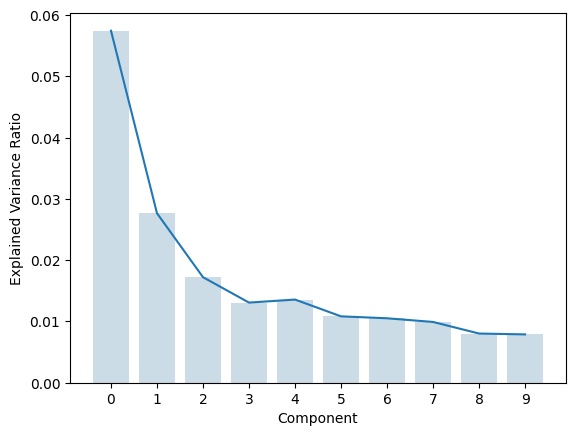

In [7]:
# Plot the explained variance ratios of the components 
sns.barplot(x=range(svd.explained_variance_ratio_.__len__()), y=svd.explained_variance_ratio_, alpha=0.25)
plt.plot(svd.explained_variance_ratio_)
plt.xlabel('Component')
plt.ylabel('Explained Variance Ratio')


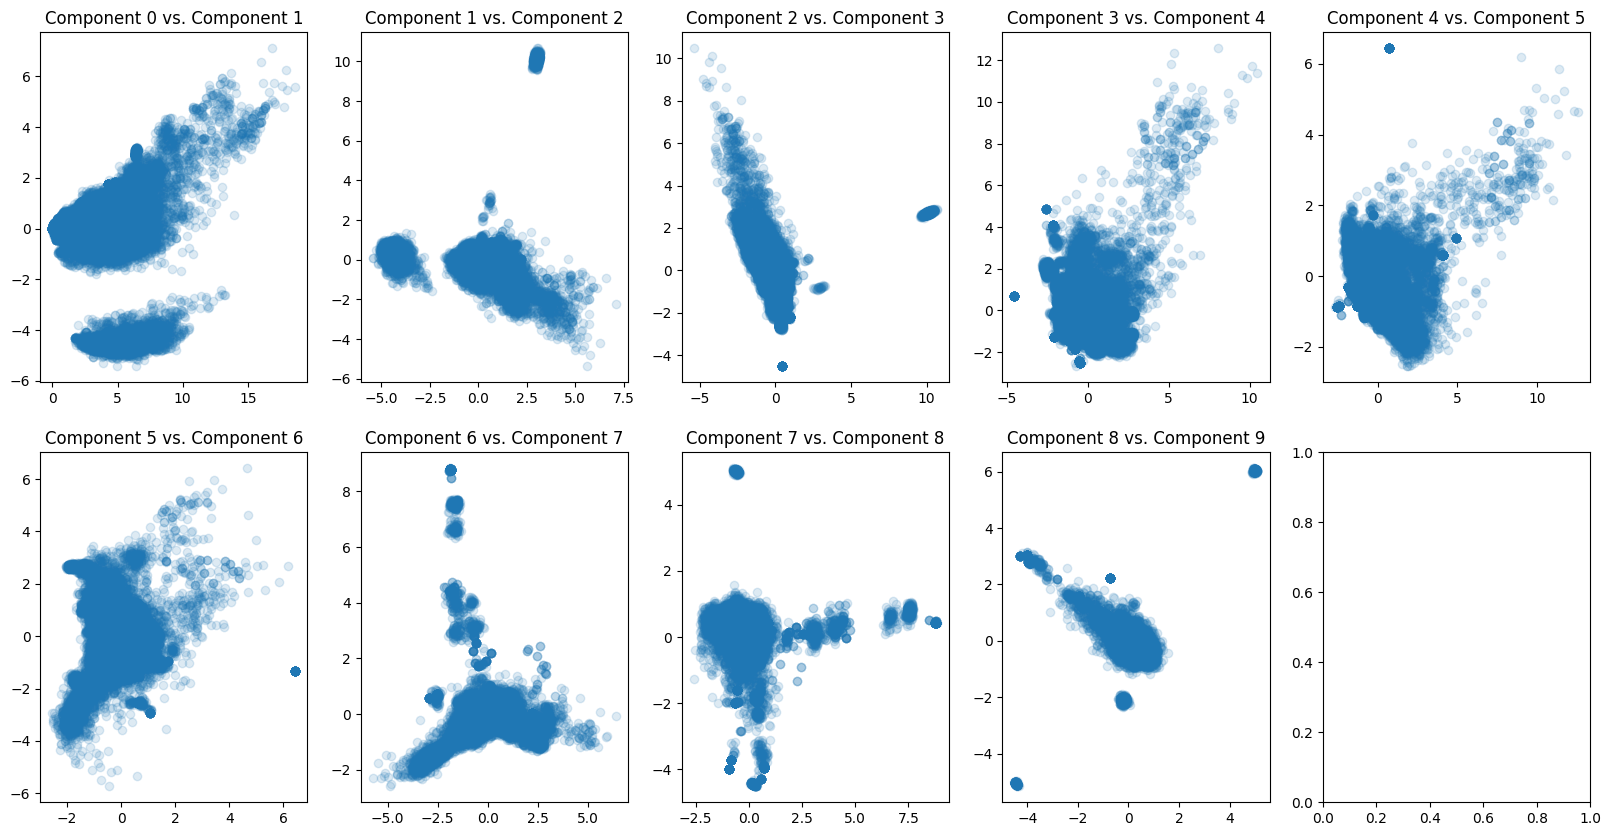

In [8]:
# Create a scatter plot using the two components with the highest explained variance
# ratios (Hint: plt.scatter(proj_matrix[:, i], proj_matrix[:, j])).
# What do you observe?
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i, j in enumerate(matrix_proj):
    if i >= 9:
        continue
    axes[i//5, i%5].scatter(matrix_proj[:, i], matrix_proj[:, i+1], alpha=0.15)
    axes[i//5, i%5].set_title(f'Component {i} vs. Component {i+1}')
plt.show()

C:\Users\goetschm\AppData\Local\Temp\ipykernel_19832\3546250316.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(matrix_proj[:, 0], matrix_proj[:, 1],


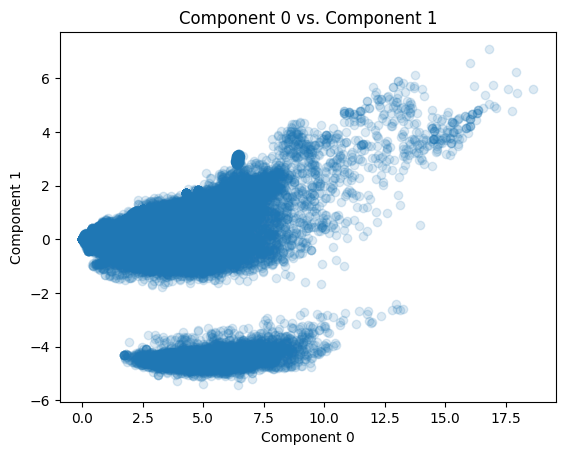

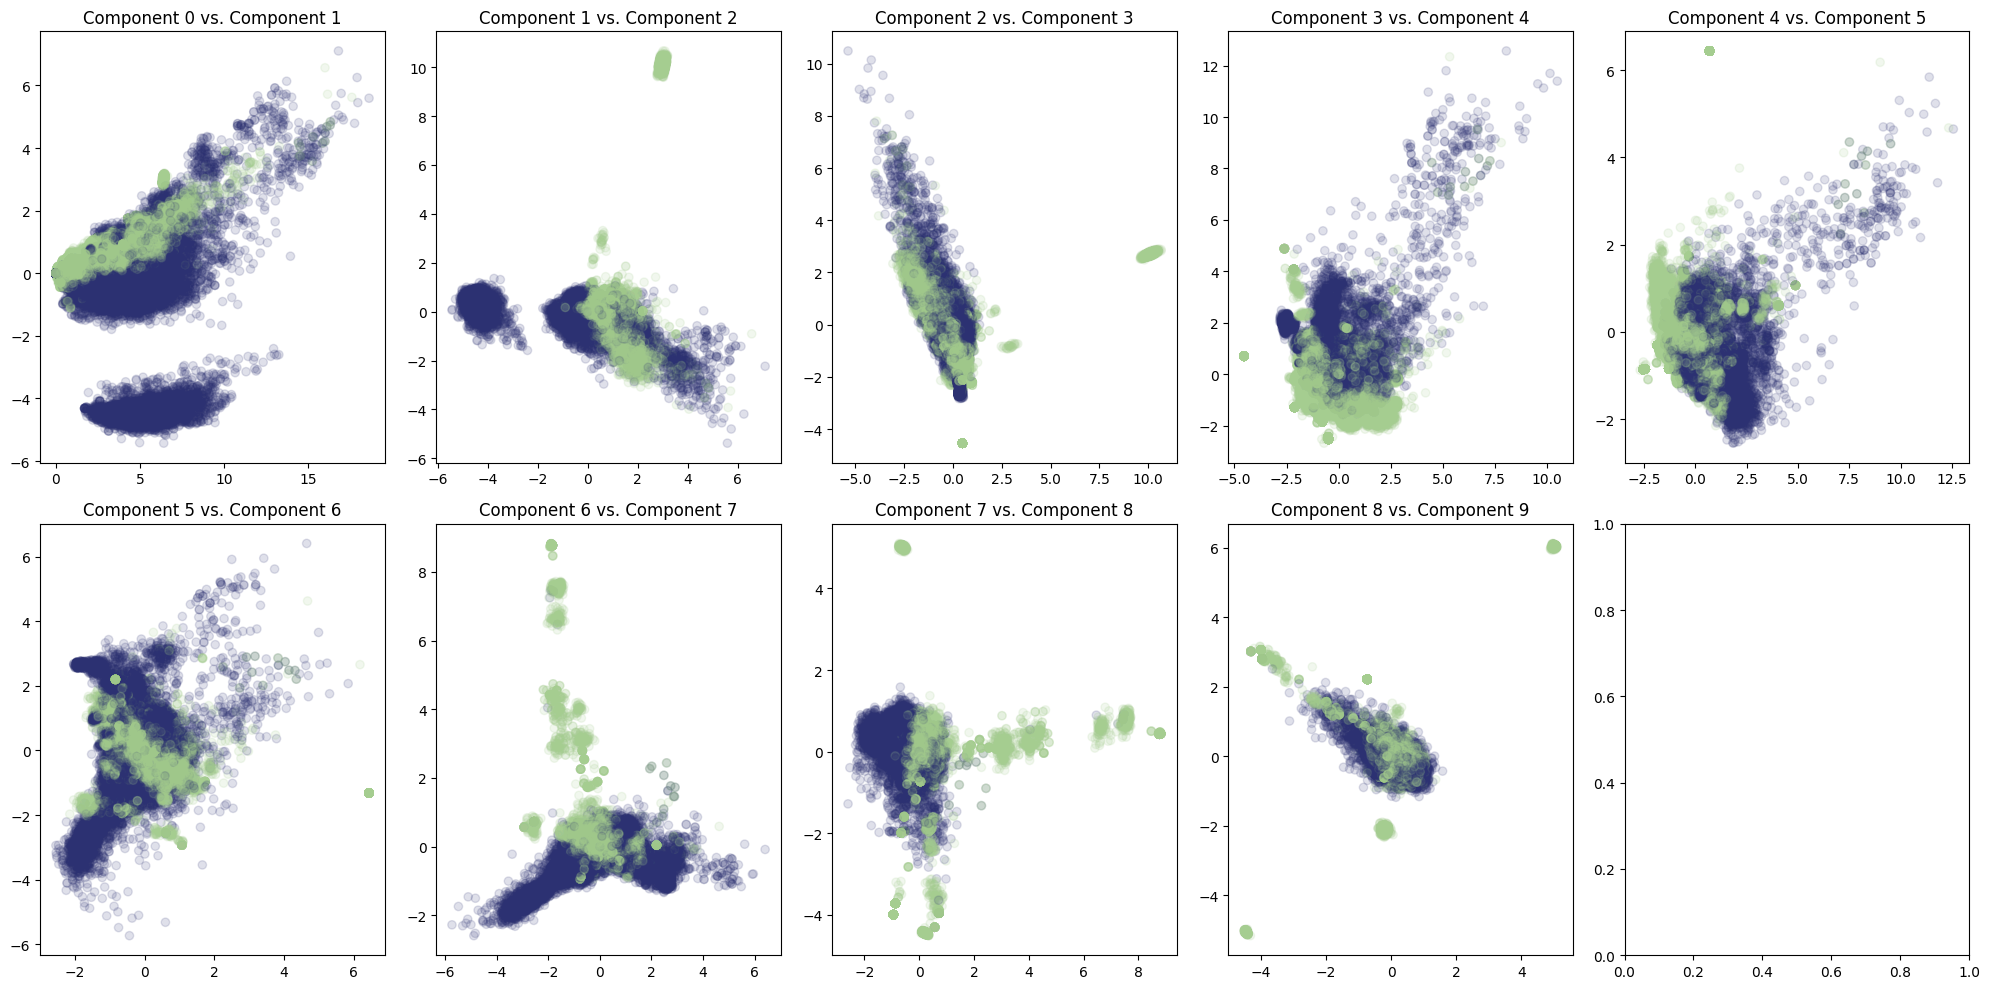

In [40]:
# Create a second scatter plot using the same two components.
# This time, color the points based on the category column of the DataFrame.
# All spam messages should be one color; all ham messages should be a second color.
plt.scatter(matrix_proj[:, 0], matrix_proj[:, 1],
            c=df['category'].apply(lambda x: 0 if x == 'spam' else 1),
            alpha=0.15, cmap='crest')
plt.xlabel('Component 0')
plt.ylabel('Component 1')
plt.title('Component 0 vs. Component 1')
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for i, j in enumerate(matrix_proj):
    if i >= 9:
        continue
    axes[i//5, i % 5].scatter(matrix_proj[:, i], matrix_proj[:, i+1], 
                              c=df['category'].apply(lambda x: 0 if x == 'spam' else 1), 
                              alpha=0.15, cmap='crest')
    axes[i//5, i % 5].set_title(f'Component {i} vs. Component {i+1}')
plt.tight_layout()
plt.show()

(a) Which two components have the highest explained variance ratios?
- Component 0 and 1

## Clustering


1. To perform further analysis, we want to cluster the emails. By clustering the emails, each message will be assigned a cluster id (e.g., 0, 1, 2, etc.). There are numerous clustering algorithms, each with strengths and weaknesses. We cannot cover them all in lecture and so begin this section by reviewing the clustering algorithms available in Scikit Learn. Choose a clustering algorithm that you think would be appropriate for this data set.

In [10]:
# scaler = StandardScaler()
# matrix_proj_scaled = scaler.fit_transform(matrix_proj)

# HDBSCAN
# hbd = HDBSCAN(min_cluster_size=2000)
# db = DBSCAN(eps=0.5, min_samples=2000)


2. Cluster the samples using the two SVD components that you determined to have
the highest explained ratio AFTER performing any necessary operations to transform
them. The clustering algorithm should return a 1D numpy array of cluster labels (e.g.,
0, 1, 2, etc.) for each point.


In [11]:
# SVD components: matrix_proj[: , :2]

# hdb_clusters = hbd.fit_predict(matrix_proj[:, :2])
# hdb_clusters_scaled = hbd.fit_predict(matrix_proj_scaled[:, :2])
# bd_clusters = db.fit_predict(matrix_proj[:, :2])
# bd_clusters_scaled = db.fit_predict(matrix_proj_scaled[:, :2])

Cluster size: 1500, Number of clusters: 5
col_0           -1         0         1         2         3
category                                                  
ham       0.249315  0.083457  0.003321  0.002408  0.024913
spam      0.369142  0.000000  0.105820  0.050565  0.111060


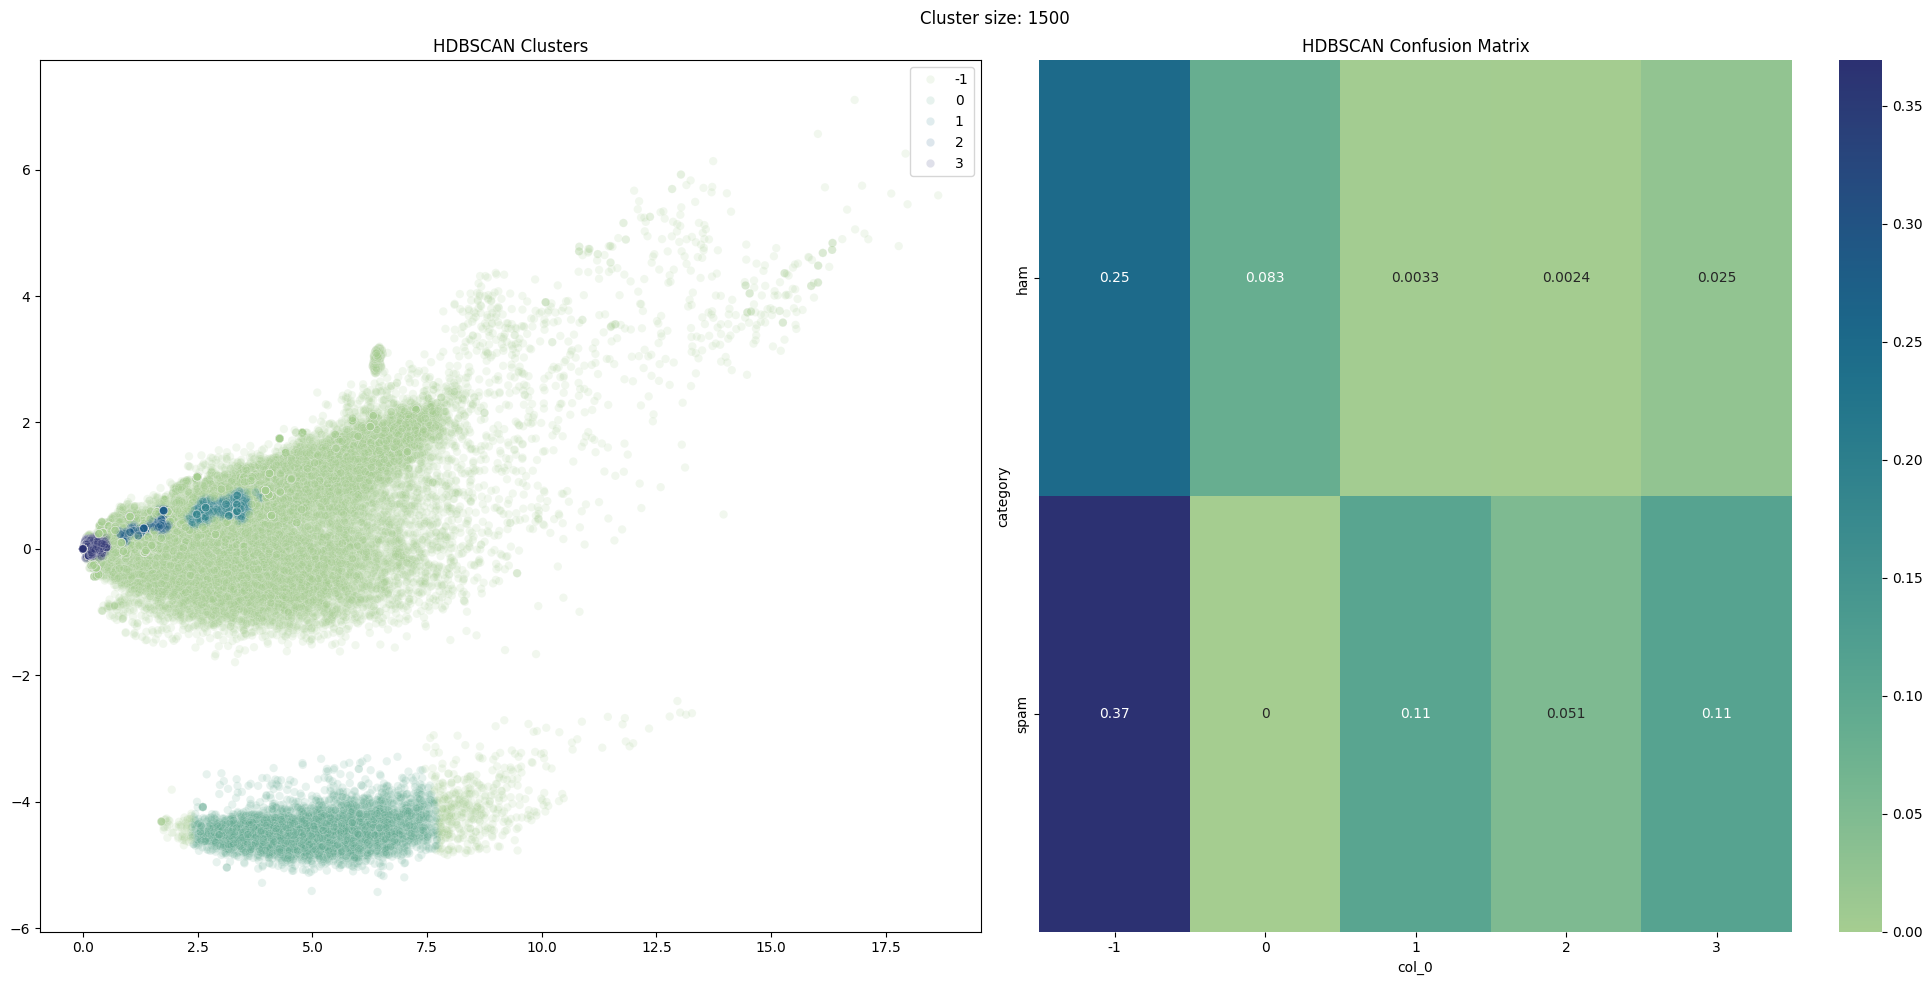

Cluster size: 2000, Number of clusters: 5
col_0           -1         0         1         2         3
category                                                  
ham       0.254997  0.078672  0.003431  0.001385  0.024928
spam      0.367458  0.000000  0.112650  0.044506  0.111973


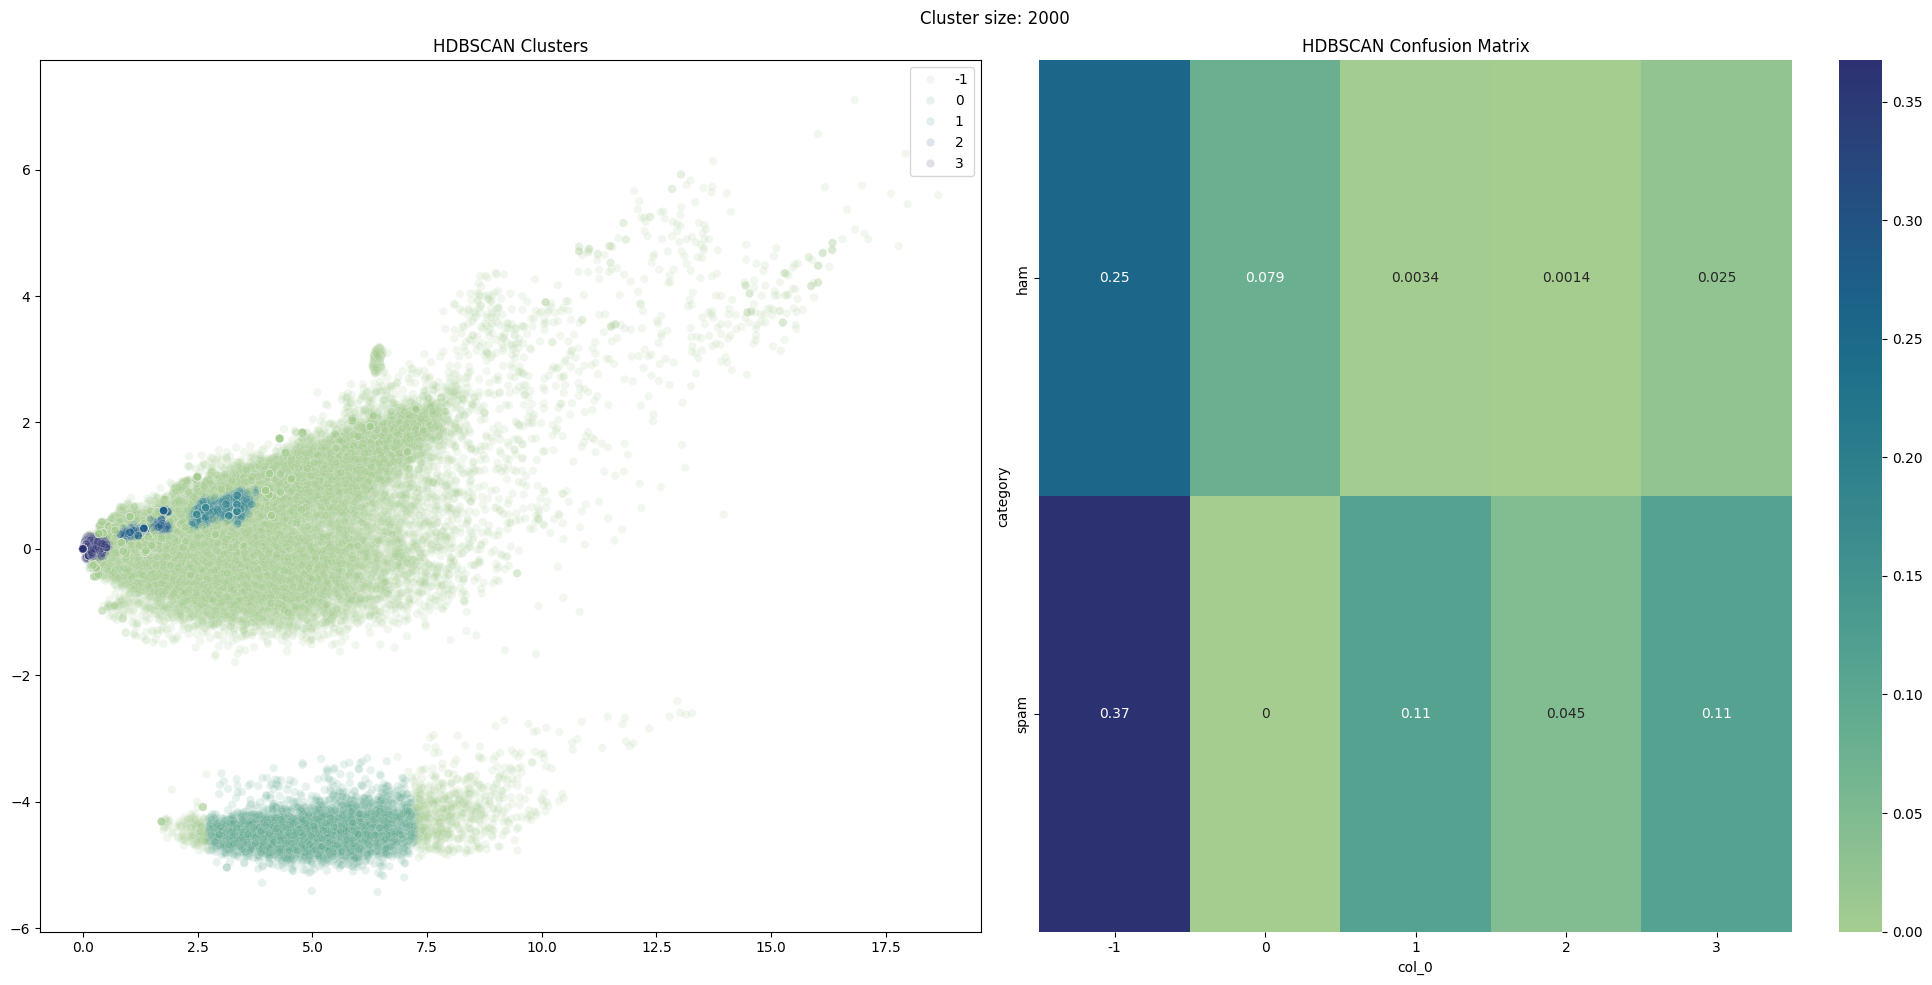

Cluster size: 2500, Number of clusters: 4
col_0           -1         0        1         2
category                                       
ham       0.257609  0.072708  0.02987  0.003226
spam      0.307497  0.000000  0.21688  0.112209


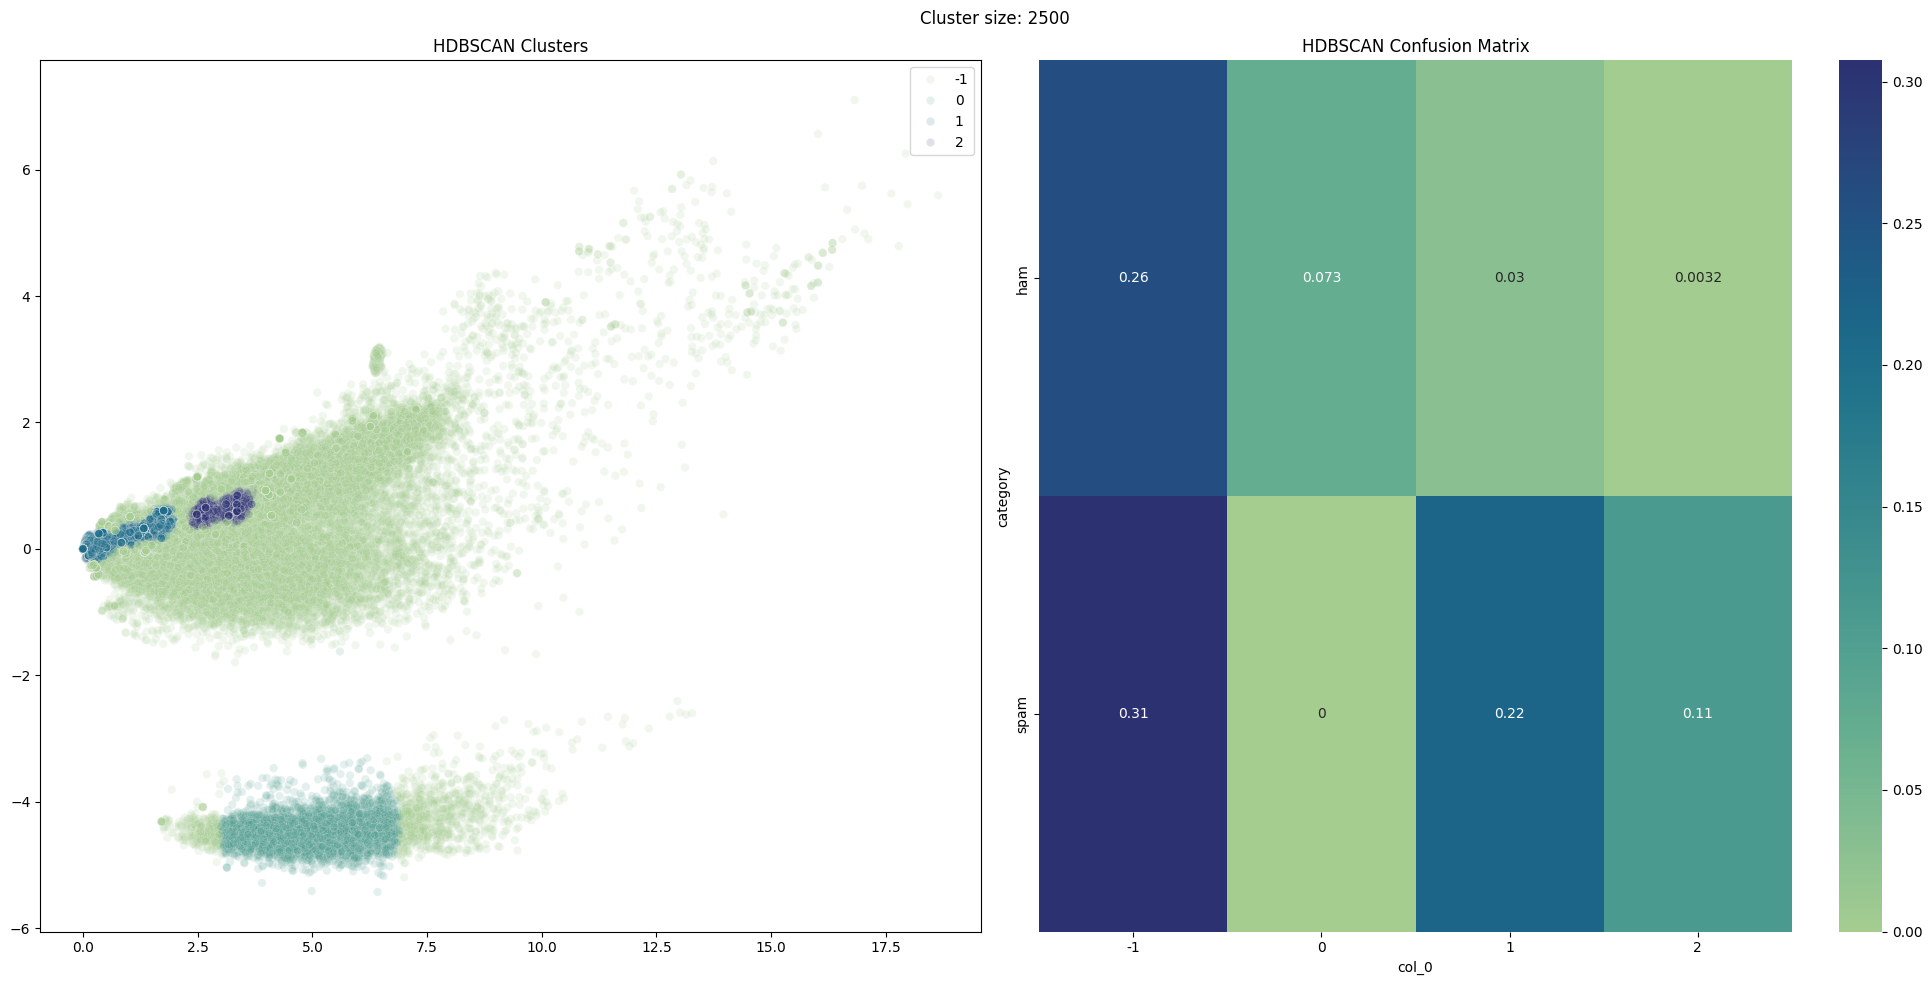

Cluster size: 3000, Number of clusters: 4
col_0           -1         0         1         2
category                                        
ham       0.267697  0.064682  0.028941  0.002093
spam      0.321236  0.000000  0.209594  0.105757


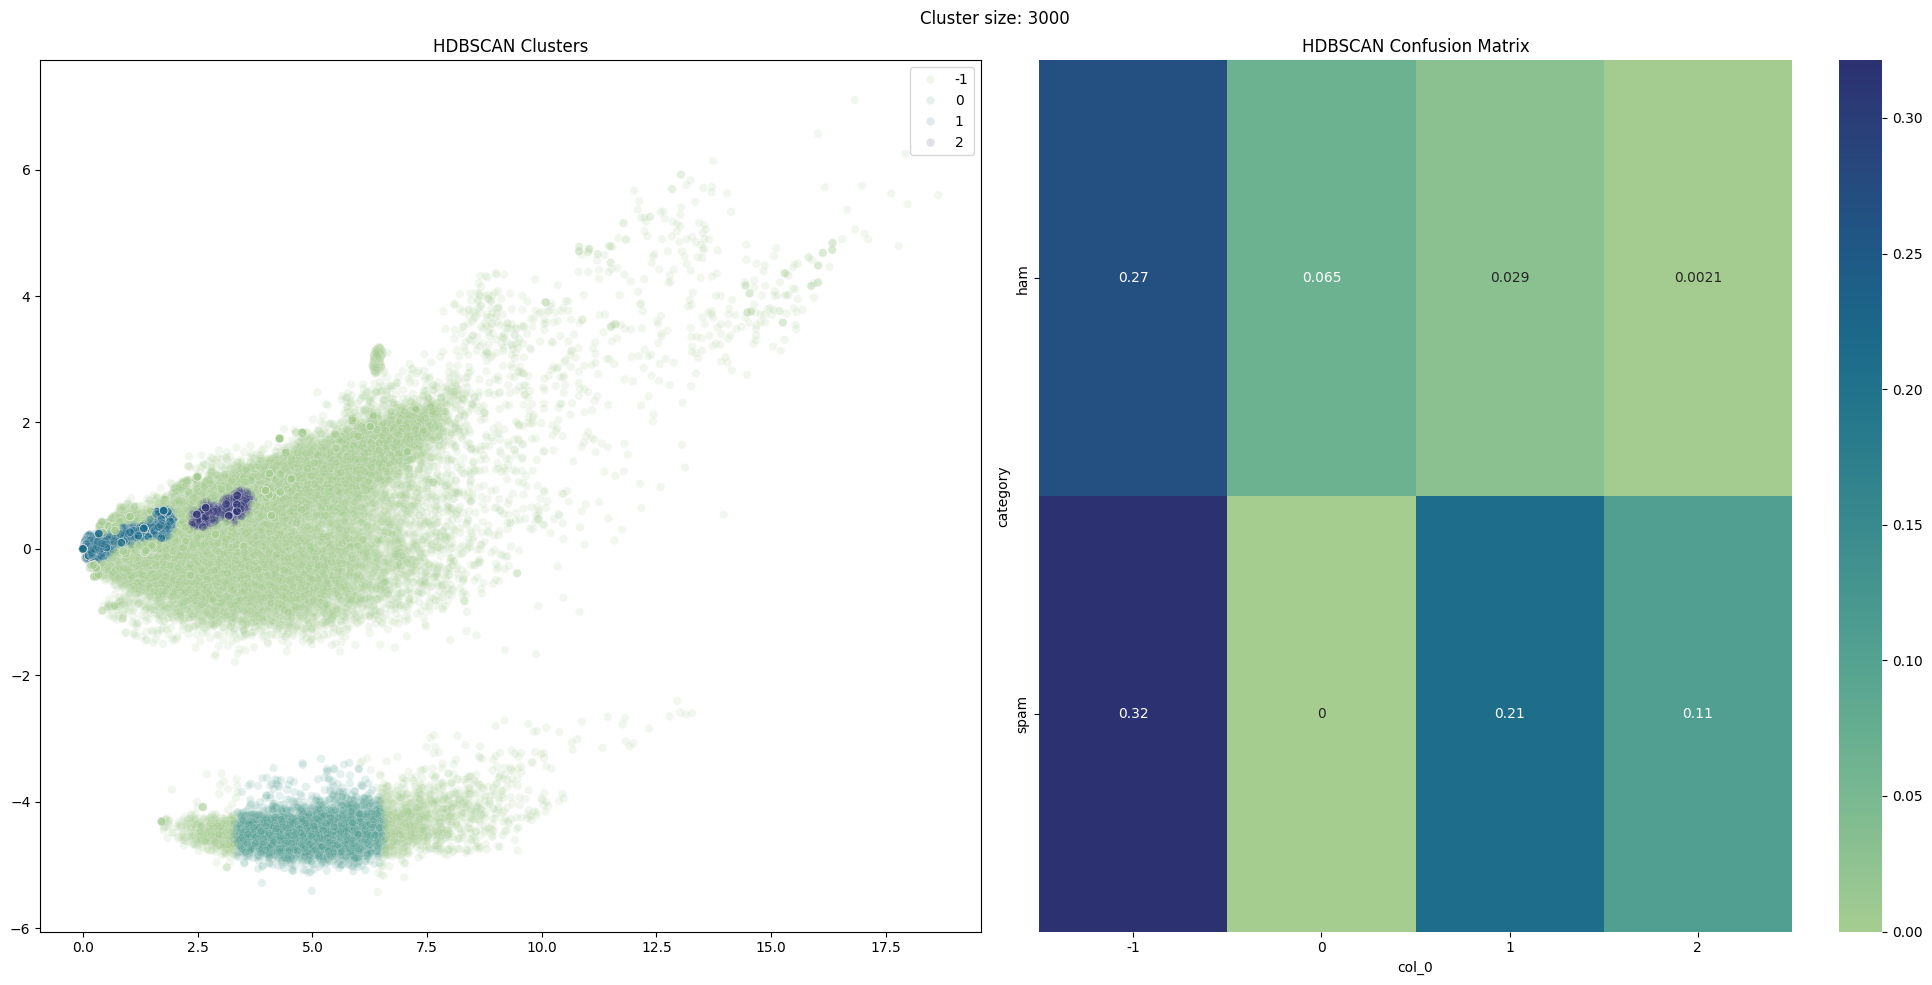

Cluster size: 3500, Number of clusters: 3
col_0           -1         0         1
category                              
ham       0.335085  0.026848  0.001479
spam      0.369692  0.174483  0.092411


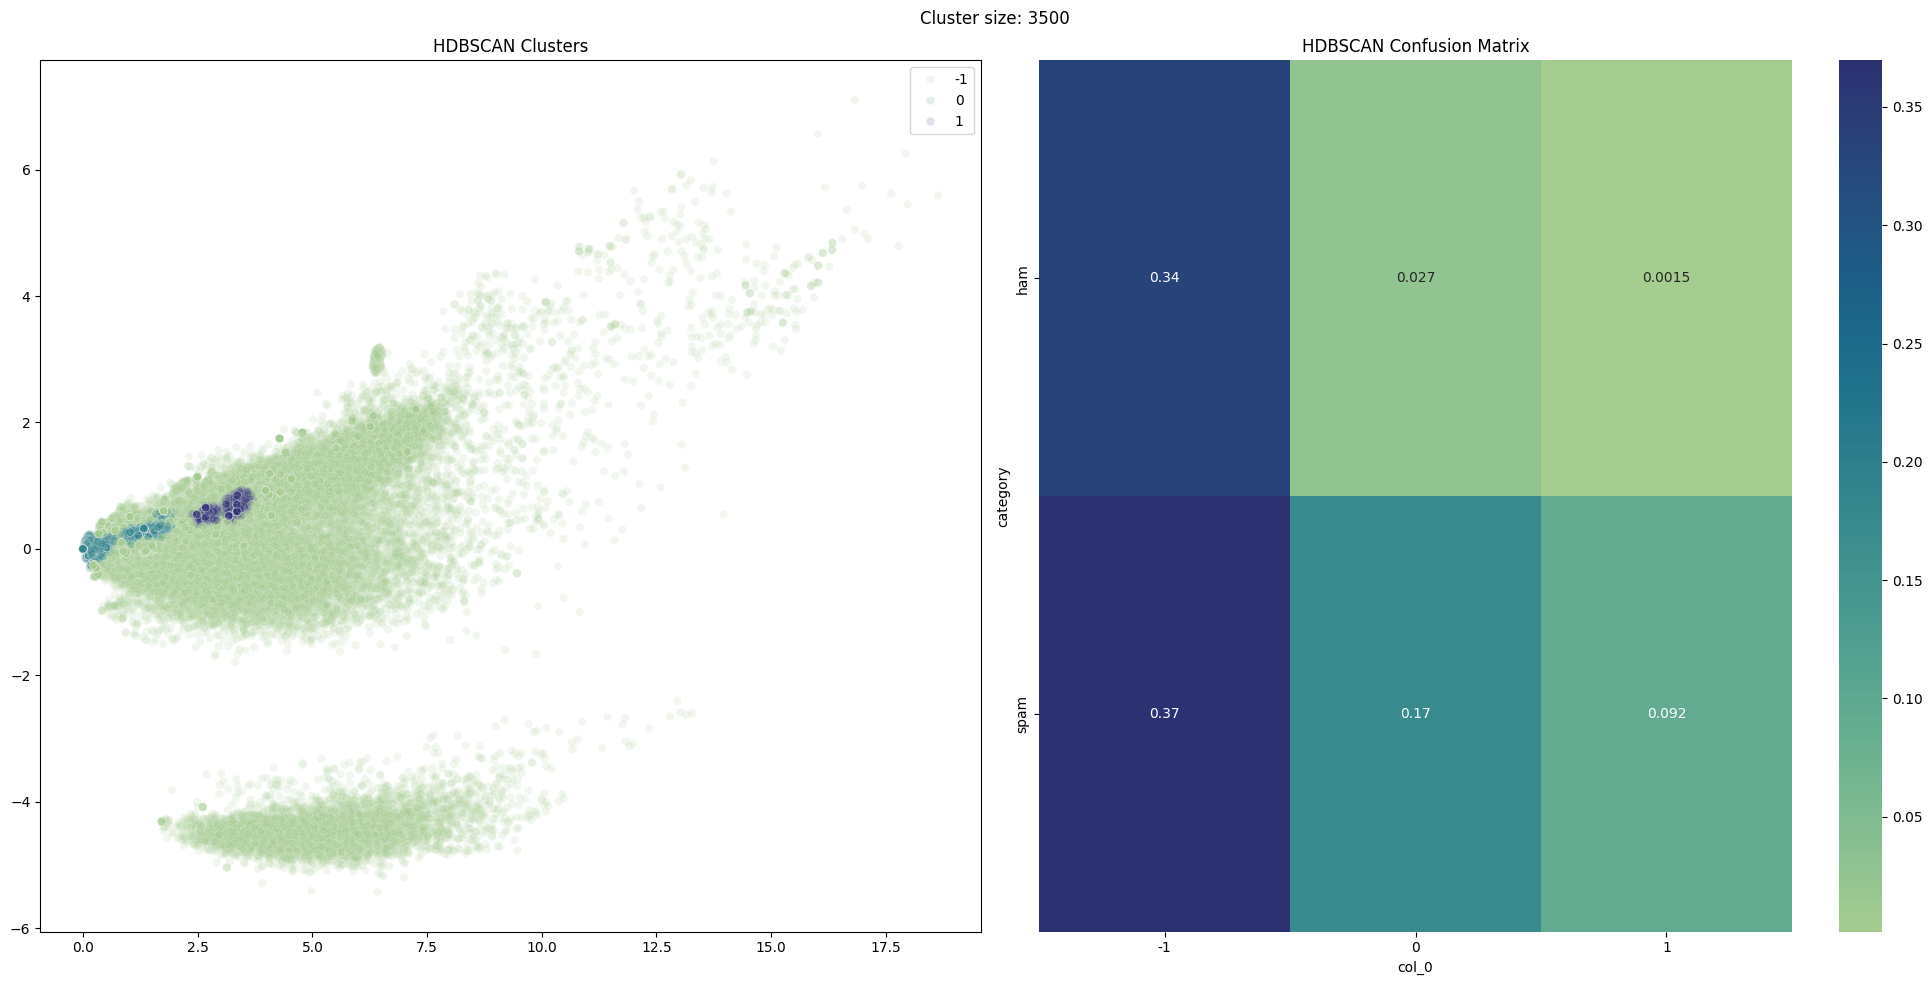

Cluster size: 4000, Number of clusters: 3
col_0           -1         0         1
category                              
ham       0.335731  0.026408  0.001275
spam      0.394526  0.161153  0.080907


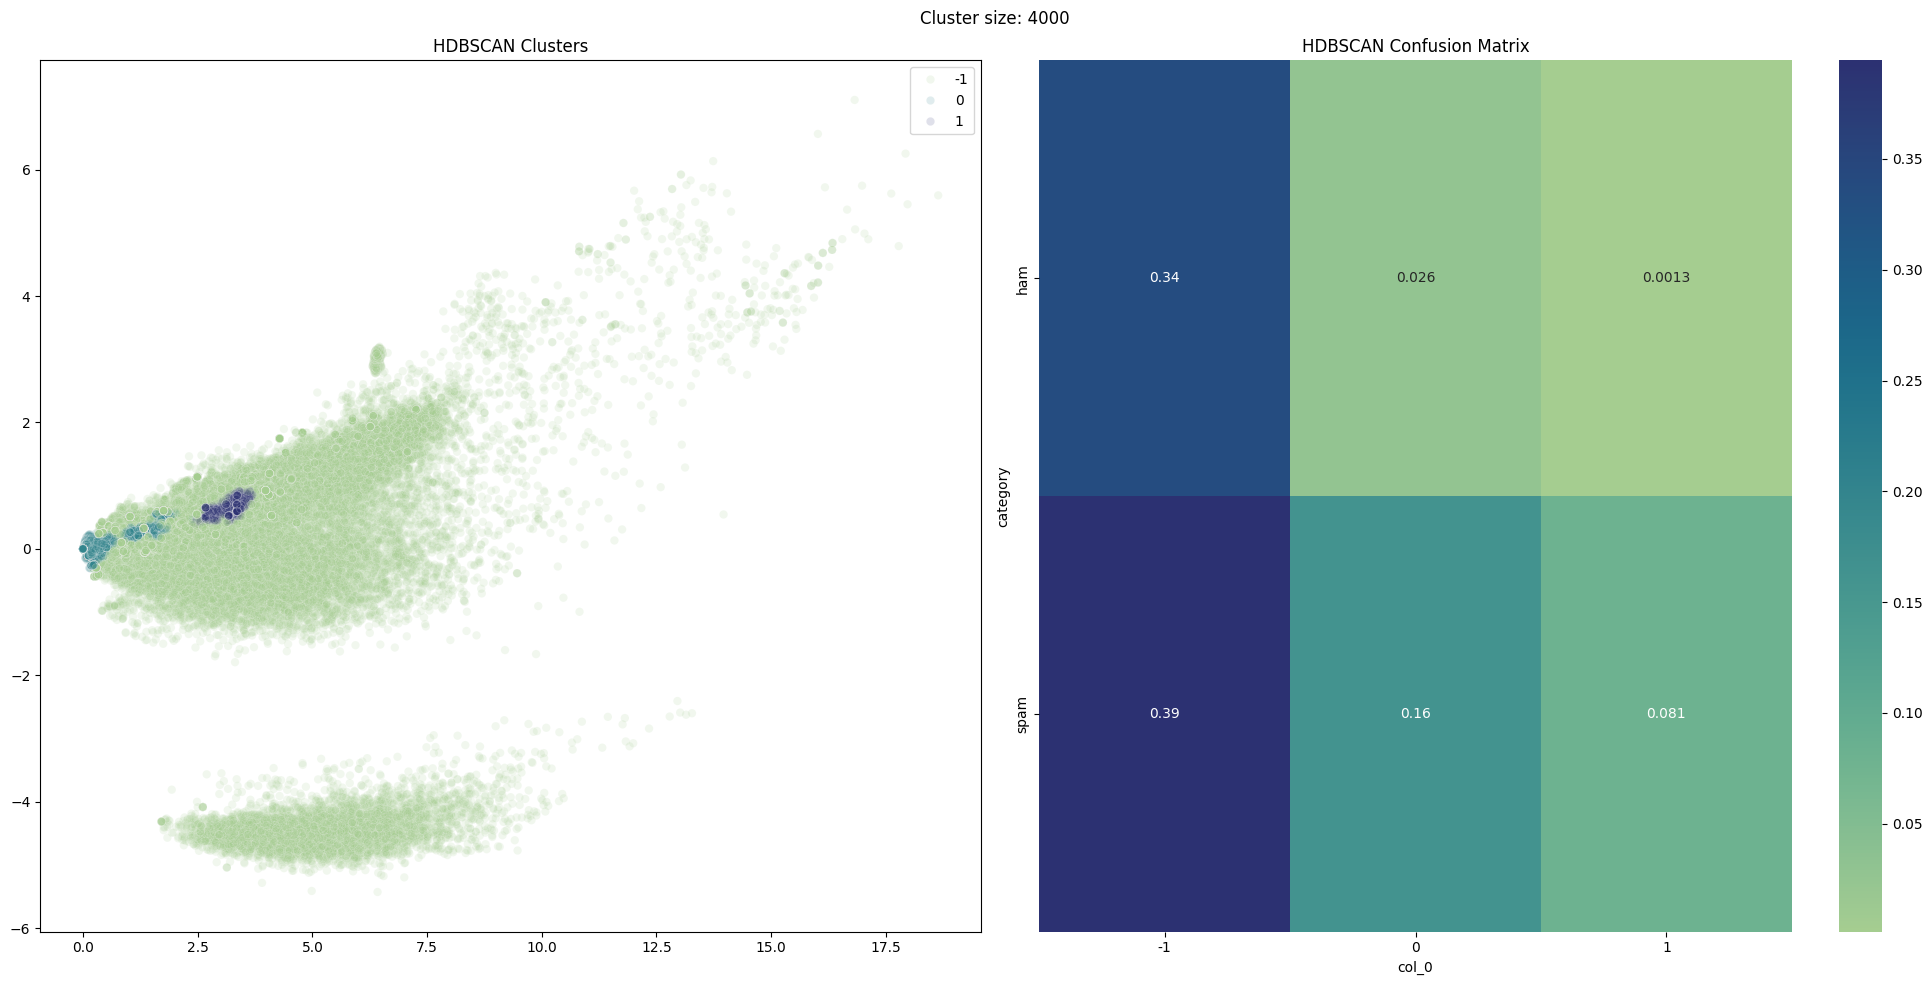

Cluster size: 4500, Number of clusters: 3
col_0           -1         0         1
category                              
ham       0.335432  0.026675  0.001306
spam      0.389270  0.171021  0.076296


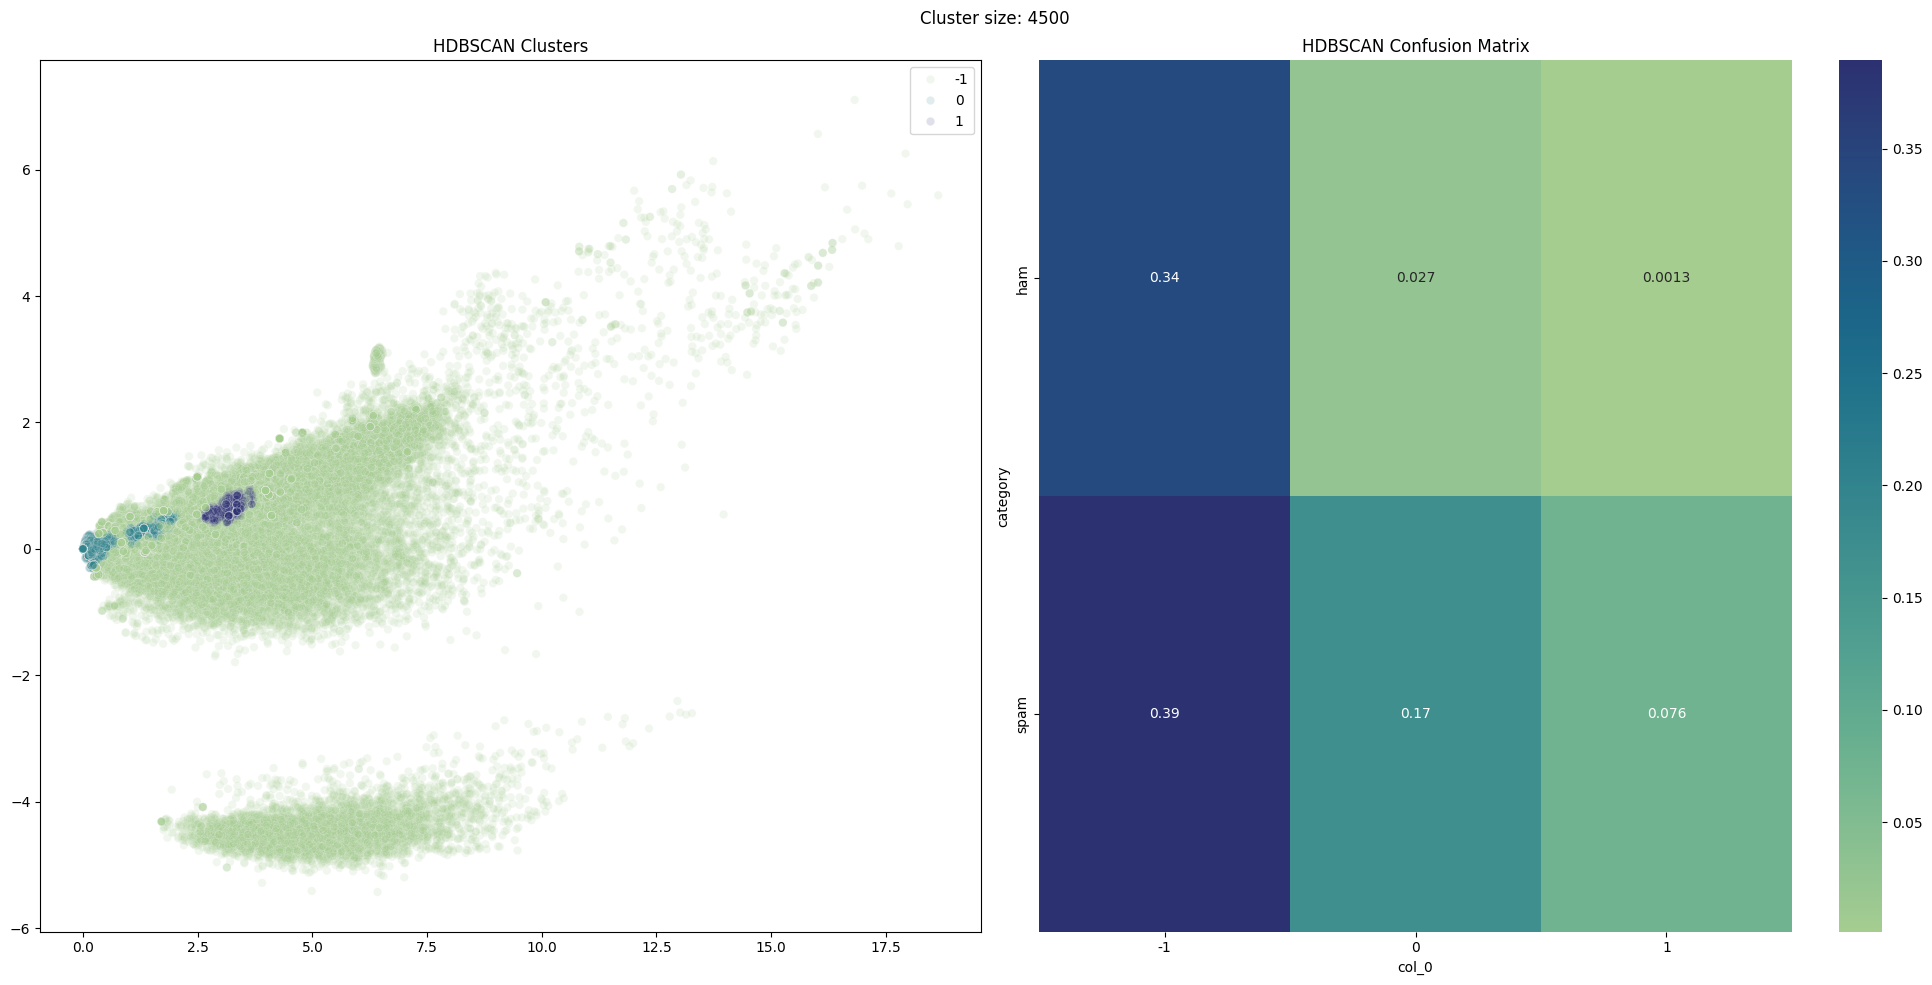

Cluster size: 5000, Number of clusters: 3
col_0           -1         0         1
category                              
ham       0.334283  0.027635  0.001495
spam      0.370275  0.186113  0.080199


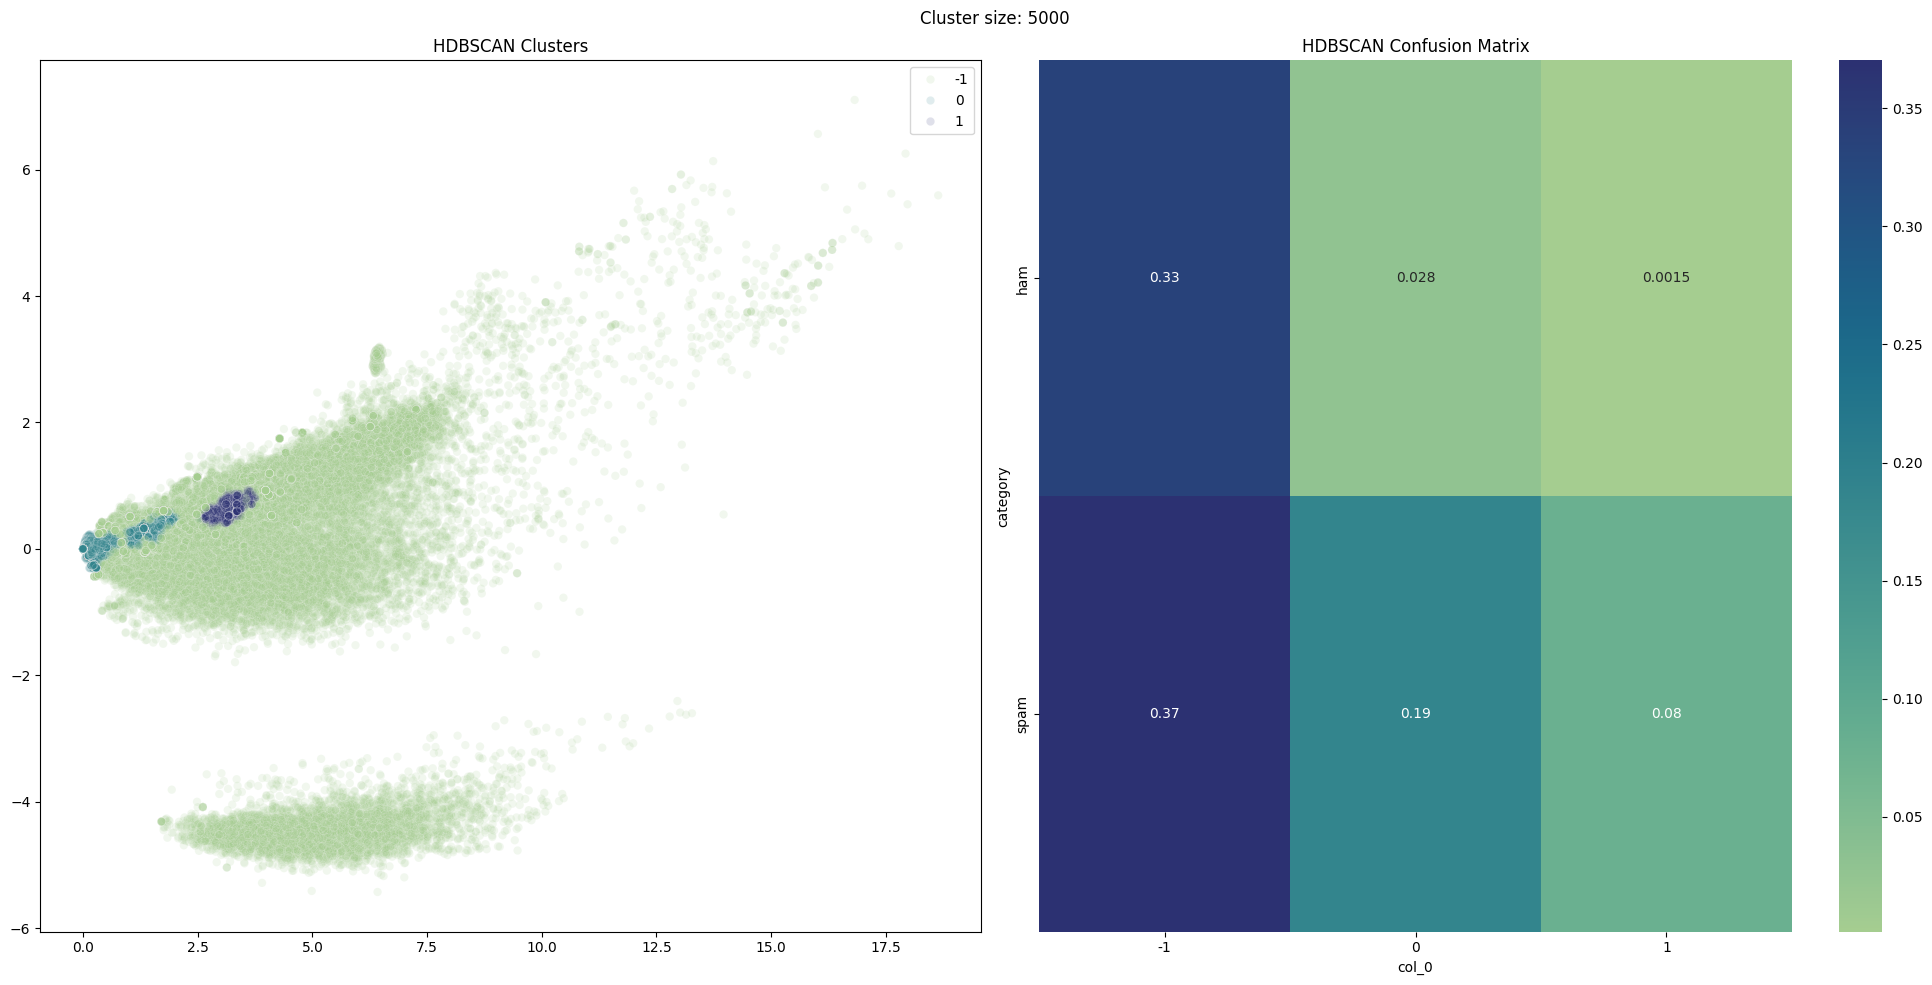

Cluster size: 5500, Number of clusters: 1
col_0           -1
category          
ham       0.363413
spam      0.636587


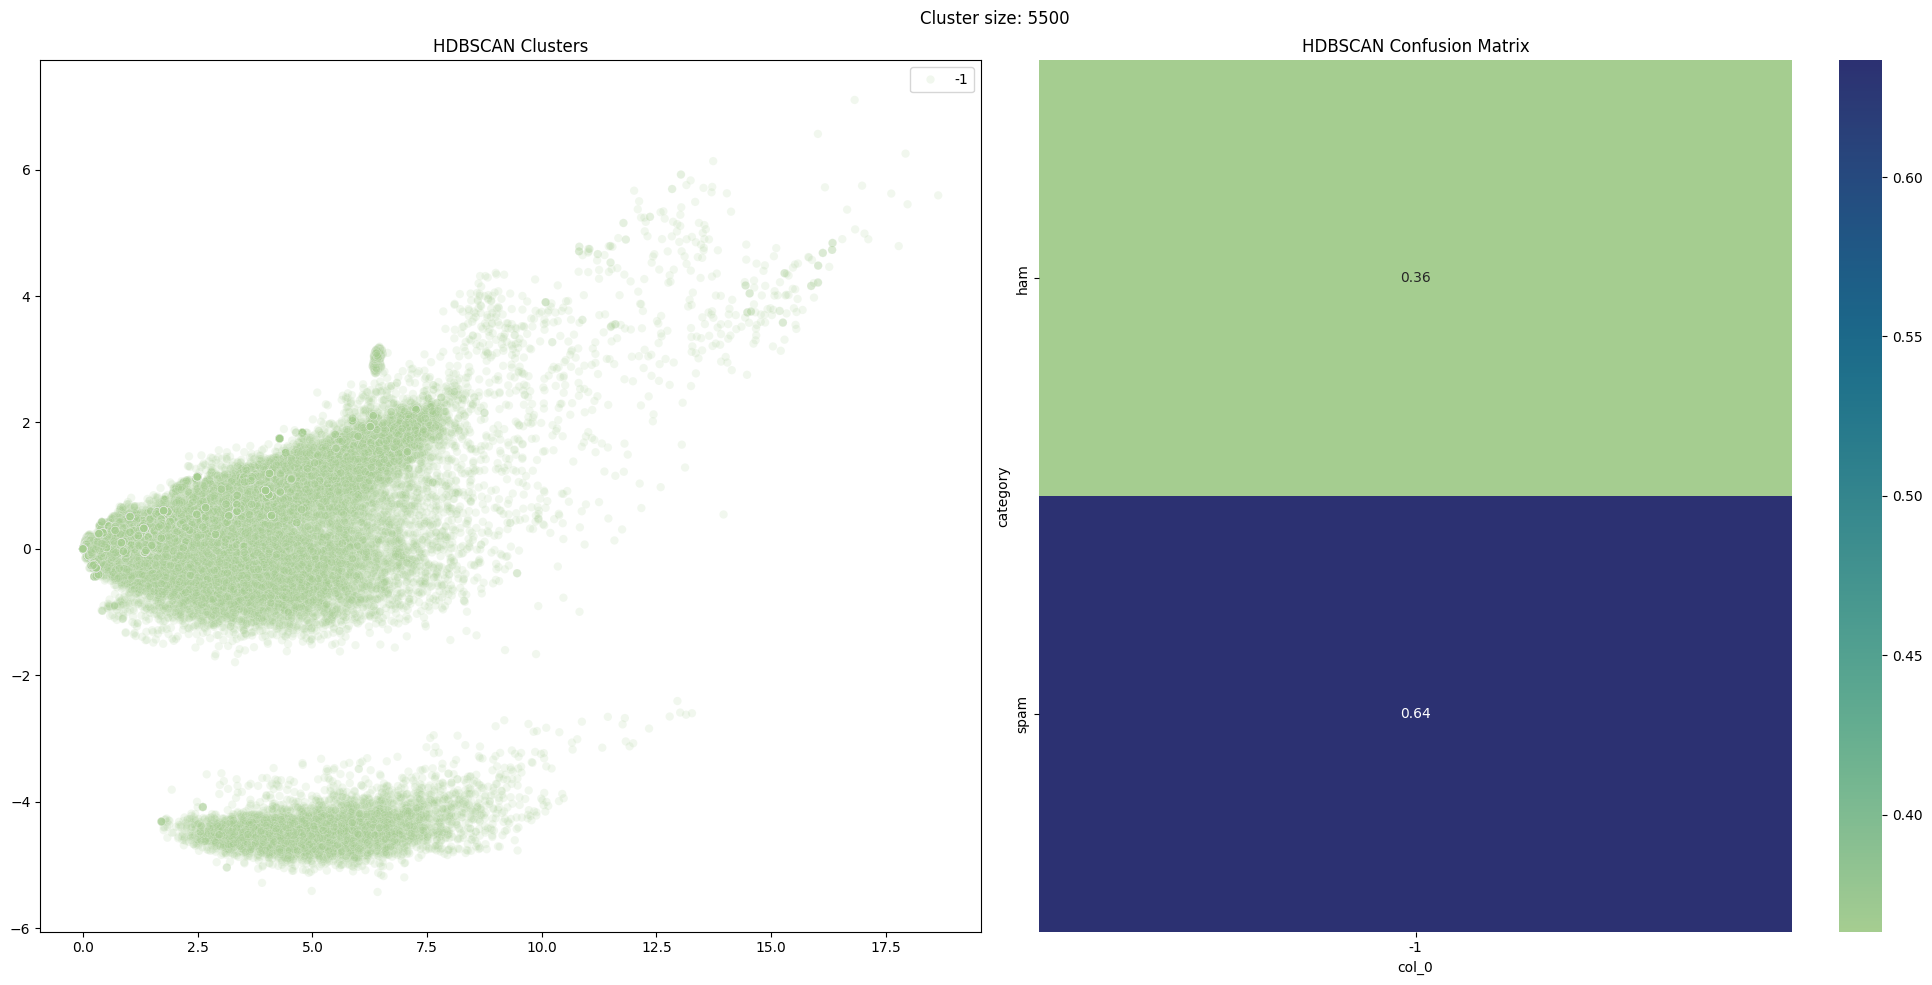

In [12]:
cluster_sizes = range(1500, 6000, 500)
cluster_collection = []
for size in cluster_sizes:
    hbd = HDBSCAN(min_cluster_size=size)
    hdb_clusters = hbd.fit_predict(matrix_proj[:, :2])
    cluster_collection.append(hdb_clusters)
    
    print(f"Cluster size: {size}, Number of clusters: {len(set(hdb_clusters))}")
    confusion_matrix = pd.crosstab(df['category'], 
                                   hdb_clusters, normalize=True)
    print(confusion_matrix)

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle(f"Cluster size: {size}")
    axes[0].set_title('HDBSCAN Clusters')
    sns.scatterplot(data=df, x=matrix_proj[:, 0], y=matrix_proj[:, 1],
                    hue=hdb_clusters, alpha=0.15, palette='crest', ax=axes[0])

    axes[1].set_title('HDBSCAN Confusion Matrix')
    sns.heatmap(confusion_matrix, annot=True, cmap='crest', ax=axes[1])

    plt.tight_layout()
    plt.show()

In [13]:
# cluster_collection[0]
# c1 = [0.8 if x == -1 else .0007 for x in cluster_collection[0]]
# sns.scatterplot(data=df, x=matrix_proj[:, 0], y=matrix_proj[:, 1], alpha=c1, palette='crest')

3. As in 3.4., create a scatter plot of the two SVD components that you determined to
have the highest explained ratio. The clustering algorithm should label the points so
that all points in the same cluster have the same cluster id (With two clusters, there
should only be two cluster ids). Color the points according to their cluster labels. If
the clustering does not look correct, try adjusting the parameters of the clustering
algorithm you chose or choose a different algorithm.


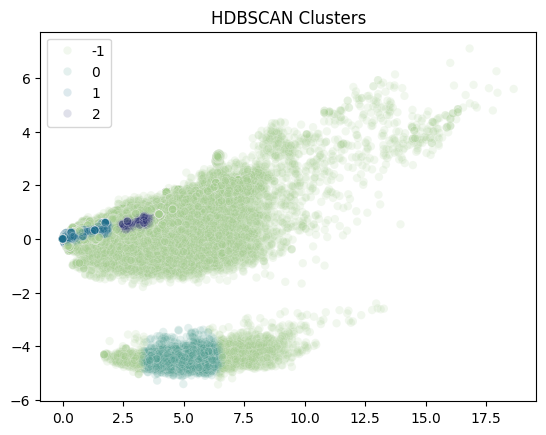

In [14]:
# plot the clusters
hdb_clusters = cluster_collection[3]

# plt.scatter(matrix_proj[:, 0], matrix_proj[:, 1], c=hdb_clusters, 
#             alpha=0.1, cmap='crest')
plt.title('HDBSCAN Clusters')
sns.scatterplot(data=df, x=matrix_proj[:, 0], y=matrix_proj[:, 1], 
                hue=hdb_clusters, alpha=0.15, palette='crest')
plt.show()

# other options :p
# plt.scatter(matrix_proj_scaled[:, 0], matrix_proj_scaled[:, 1], c=hdb_clusters_scaled, 
#             alpha=0.1, cmap='crest')
# plt.title('HDBSCAN Scaled Clusters')
# plt.show()

# plt.scatter(matrix_proj[:, 0], matrix_proj[:, 1], c=bd_clusters,
#             alpha=0.05, cmap='crest')
# plt.title('DBSCAN Clusters')
# plt.show()

# plt.scatter(matrix_proj_scaled[:, 0], matrix_proj_scaled[:, 1], c=bd_clusters_scaled,
#             alpha=0.1, cmap='crest')
# plt.title('DBSCAN Scaled Clusters')
# plt.show()

4. Calculate a confusion matrix for the ham / spam labels versus the cluster labels.


col_0           -1         0         1         2
category                                        
ham       0.267697  0.064682  0.028941  0.002093
spam      0.321236  0.000000  0.209594  0.105757


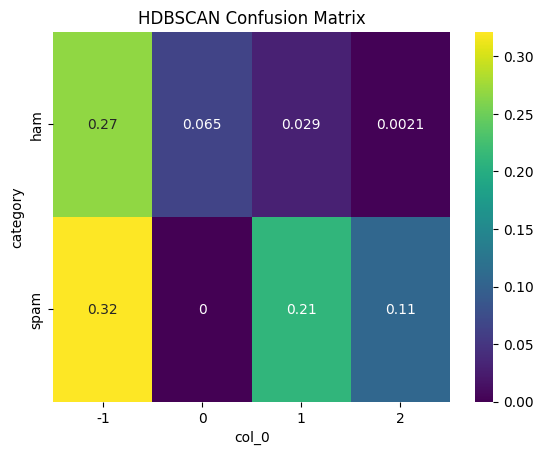

In [15]:
# confusion matrix
# confusion matrix for HDBSCAN
confusion_matrix = pd.crosstab(df['category'], hdb_clusters, normalize=True)
print(confusion_matrix)
sns.heatmap(confusion_matrix, annot=True, cmap='viridis')
plt.title('HDBSCAN Confusion Matrix')
plt.show()

# confusion_matrix = pd.crosstab(df['category'], hdb_clusters_scaled)
# print(confusion_matrix)
# sns.heatmap(confusion_matrix, annot=True, cmap='viridis')
# plt.title('HDBSCAN Confusion Matrix')
# plt.show()

# # confusion matrix for DBSCAN
# confusion_matrix = pd.crosstab(df['category'], bd_clusters)
# print(confusion_matrix)
# sns.heatmap(confusion_matrix, annot=True, cmap='viridis')
# plt.title('DBSCAN Confusion Matrix')
# plt.show()

# confusion_matrix = pd.crosstab(df['category'], bd_clusters_scaled)
# print(confusion_matrix)
# sns.heatmap(confusion_matrix, annot=True, cmap='viridis')
# plt.title('DBSCAN Confusion Matrix')
# plt.show()


col_0            0         1
category                    
ham       0.332379  0.031035
spam      0.321236  0.315350


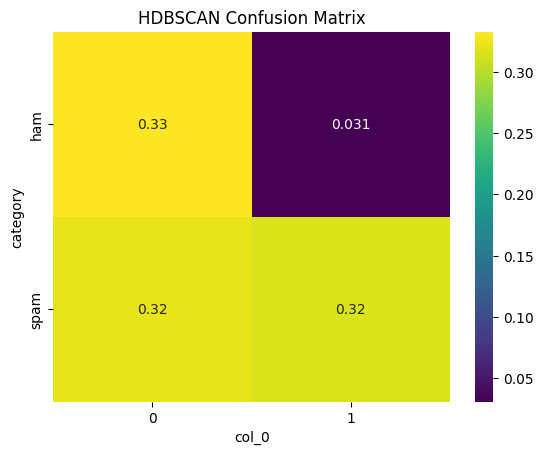

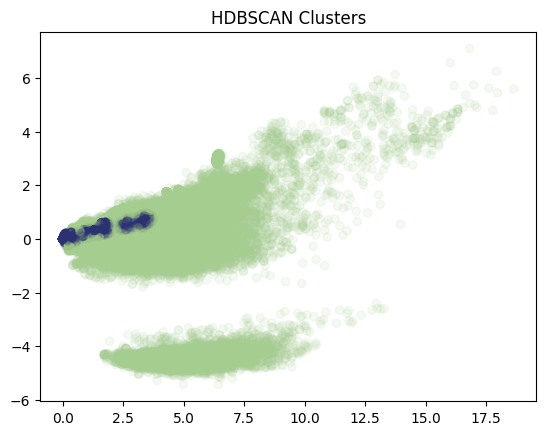

In [16]:
# combine cluster 0 and 1  to have 2 clusters
hdb_clusters[hdb_clusters == -1] = 0
hdb_clusters[hdb_clusters == 2] = 1

confusion_matrix = pd.crosstab(df['category'], hdb_clusters, normalize=True)
print(confusion_matrix)
sns.heatmap(confusion_matrix, annot=True, cmap='viridis')
plt.title('HDBSCAN Confusion Matrix')
plt.show()

plt.scatter(matrix_proj[:, 0], matrix_proj[:, 1], c=hdb_clusters,
            alpha=0.1, cmap='crest')
plt.title('HDBSCAN Clusters')
plt.show()

(a) Assess the cluster assignments. Visually, the data should form two distinct groups
or clusters. What sort of structure do you observe? Do you think that clustering
will allow you to recover the label?
- To get a clean seperation of the clusters, I used HDBSCAN to cluster a higher amount of clusters then combined them into two clusters. Even with this, the clusters are somewhat the same, with one cluster being more likely to be not ham really being the only difference. I think that clustering will allow me to recover the label, but it will not be perfect in the slightest.

(b) Why did you choose the clustering algorithm that you did?
- HBDSCAN is useful because the data is not spherical and the clusters are not of equal size. It is also useful because it can find clusters of varying density
- I tried both to see which one would work better.

(c) What sort of transformations do you need to apply to your data prior to clustering? Why are they necessary?
- I need to apply SVD to reduce the dimensionality of the data. This is necessary because the data is high-dimensional and clustering algorithms do not perform well in high-dimensional spaces.
- I did not need to apply any other transformations because the data was already normalized, and the clustering algorithms I used do not require the data to be centered.

(d) Compare the ham/spam labels to the cluster labels using the confusion matrix
you generated. Are spam messages in both clusters or a single cluster? Are all
of the messages in the clusters with spam labeled as spam? Was your clustering
successful?
- Spam messages are in both clusters. Not all of the messages in the clusters with spam are labeled as spam. My clustering was not successful. Visually looking at the plots, the clusters are not very distinct, and while the diffeernces in density are somewhat captured, the clusters are not very clean.

## Calculating Document Frequencies of Words


1. From part V, we now have clusters, but we don’t know why specific emails were clustered together. Let’s try to see if we can ascribe meaning to the clusters. Create a separate matrix for each cluster containing the rows for the points in that cluster.

In [17]:
clusters = [matrix[hdb_clusters == cluster] for cluster in np.unique(hdb_clusters)]
# clusters = [df.iloc[hdb_clusters == cluster] for cluster in np.unique(hdb_clusters)]

2. Convert the matrices to CSC format. We will be accessing the data column-wise.
Column indexing is significantly faster for the CSC format than the CSR format (Hint:
Review the scipy.sparse module).

In [18]:
clusters = [csc_matrix(cluster) for cluster in clusters]
cluster_sizes = [cluster.shape[0] for cluster in clusters]

3. Calculate the document frequency of each word for each cluster. The document frequency is the number of documents that contain each word. Since the feature matrix is binary, we can simply sum across the columns (Note: The resulting matrices should
have the same shapes with one entry for each word in the vocabulary).

In [19]:
cluster_dfs = [cluster.sum(axis=0) for cluster in clusters]
cluster_dfs = [pd.DataFrame(data=cluster_df, 
                            columns=vectorizer.get_feature_names_out()) 
                            for cluster_df in cluster_dfs] 
cluster_dfs = [cluster_df.sort_values(by=0, axis=1, ascending=False) 
               for cluster_df in cluster_dfs]

# print the top 10 words in each cluster
for i, cluster_df in enumerate(cluster_dfs):
    print(f'Cluster {i}')
    print(cluster_df.iloc[:, :10])
    print()


Cluster 0
     the     to    and    for     of     in     is    you     on   this
0  35690  34105  33061  29818  29096  28602  27861  27640  23569  23347

Cluster 1
     the    to   you   and  your    of    is   for    in    it
0  10031  8388  8121  8108  7571  6923  6527  6340  5906  5318



## Find Enriched Words with Statistical Testing


1. We are going to use a Binomial test to determine if the number of occurrences of a given word in a given cluster is higher than what would be expected from the other cluster(you may find scipy.stats.binom test useful here). Here is the code for calculating the expected probability of a specific word based on cluster 1 and using it to test if the
word is enriched in cluster 0:
    
    ```python
    cluster_1_expected_prob = doc_freq_cluster_1 / num_emails_cluster_1
    pvalue = stats.binom_test(doc_freq_cluster_0, num_emails_cluster_0,
                              cluster_1_expected_prob, alternative='greater')
    ```

  The null hypothesis that the relative document frequencies of the observed cluster are less or equal to those of the tested. The alternative hypothesis is that the document frequency is higher in cluster 0 than cluster 1.


In [31]:
def check_enrichment(cluster0, cluster1, word):
    doc_freq0 = cluster_dfs[cluster0][word].sum()
    doc_freq1 = cluster_dfs[cluster1][word].sum()
    num_emails0 = cluster_sizes[cluster0]
    num_emails1 = cluster_sizes[cluster1]
    expected_prob1 = doc_freq1 / num_emails1
    if doc_freq1 == 0:
        return 1
    # print(f"Expected probability of '{word}' in cluster 0: {expected_prob1}")
    # print(f"Clusters Info: {doc_freq0}, {num_emails0}, {doc_freq1}, {num_emails1}")
    pvalue = stats.binomtest(
        k=doc_freq0, n=num_emails0, p=expected_prob1, alternative='greater')
    return pvalue.pvalue


1. Try testing if the words ”works” and ”love” are enriched in cluster 0. 


In [32]:
# test "works" and "love" enriched in cluster 0
pvalue = check_enrichment(0, 1, 'works')
print("'Works' test:", pvalue)
print()
pvalue = check_enrichment(0, 1, 'love')
print("'Love' test:", pvalue)

'Works' test: 4.967888678889228e-173

'Love' test: 3.974314719831318e-153


3. Wrap your code for 6.1. in a loop to find enriched words for cluster 0. Calculate the
p-value for every word. If the p-value < 0.05, add a tuple of (pvalue, word, cluster 0
document frequency to a list (Hint: Iterate over the vocabulary dict to get each word
and its index). When you do this filter out any words that contain non-alphabetic
characters (Hint: Use the isalpha() method of strings).


In [33]:
sig_words0 = []

for word in vectorizer.vocabulary_:
    if word.isalpha():
        pvalue = check_enrichment(0, 1, word)
        if pvalue < 0.05:
            sig_words0.append((pvalue, word, cluster_dfs[0][word].sum()))

4. Sort the words in ascending order by their p-values and print out the first 200 words.


In [34]:
sig_words = pd.DataFrame(sig_words0, columns=['pvalue', 'word', 'freq'])
sig_words['cluster'] = 0
sig_words.sort_values(by='pvalue', ascending=True, inplace=True)
for word in sig_words['word'].head(200):
    print(word)

sig_words

do
warner
georgia
atlanta
center
lllp
lp
cable
alerting
personalized
colleague
rights
refer
frequency
criteria
manage
settings
preference
agreed
law
top
technologies
input
custom
reserved
terms
privacy
situation
fix
want
makes
happens
reader
earlier
near
unfortunately
except
aren
building
calls
calling
asking
security
national
unix
return
traveling
returns
returned
guidelines
attorney
editor
house
former
behalf
above
accurate
instance
encrypted
becomes
provided
forwarding
each
commission
themselves
description
job
union
account
bank
via
private
made
begin
legal
transfer
money
obvious
entrepreneurs
transaction
firm
battle
edt
pm
consider
intellectual
name
alert
considered
alerts
focus
object
enable
experience
interested
anyway
salary
branches
manager
possibility
effort
cancel
consumer
capital
beginning
net
blogs
particularly
couple
interface
makefile
produce
compiled
length
wanted
characters
flexible
appropriate
stable
requires
sources
corresponding
missing
vector
alternative
deleted
ne

pvalue              word   freq  cluster
0     0.000000                do  16179        0
1356  0.000000            warner    792        0
1355  0.000000           georgia    855        0
1354  0.000000           atlanta    952        0
1353  0.000000            center   1600        0
...        ...               ...    ...      ...
9993  0.048588              repl     20        0
7177  0.048875              ease    166        0
2954  0.049851            linkto     40        0
2957  0.049851  textbreakingnews     40        0
1450  0.049979          generics     55        0

[13608 rows x 4 columns]

5. Repeat with the clusters reversed so you can find words enriched in cluster 1.


In [35]:
sig_words1 = []

for word in vectorizer.vocabulary_:
    if word.isalpha():
        pvalue = check_enrichment(1, 0, word)
        if pvalue < 0.05:
            sig_words1.append((pvalue, word, cluster_dfs[1][word].sum()))


In [36]:
sig_words1 = pd.DataFrame(sig_words1, columns=['pvalue', 'word', 'freq'])
sig_words1['cluster'] = 1
sig_words = pd.concat([sig_words, sig_words1], axis=0)

sig_words.sort_values(by='pvalue', ascending=True, inplace=True)

for word in sig_words[sig_words['cluster'] == 1]['word'].head(200):
    print(word)

sig_words

kurzel
letzter
preis
ihre
wird
kaufen
tagen
lassen
eine
durchstarten
startet
markt
entgehen
montag
disqualify
rallye
gestartet
liste
prognose
wkn
grossen
diese
kann
maintaining
younger
erection
sex
suffer
difficulties
erectile
dysfunction
occurs
lives
lenders
hausse
ist
sie
zu
sehen
firma
sich
nicht
isin
folgenden
verlieren
moglichkeit
fugen
itemyour
viagra
mineralbusiness
loan
keeping
keine
gebiet
aktie
sehr
kursgewinn
efd
paar
zeit
finanzinvestoren
mai
heutzutage
recieved
vor
realisierter
monaten
lowest
es
dienstag
jetzt
expire
improved
das
drugmart
donnerstag
finden
ed
und
verdinen
discountclick
juni
clinically
jelly
einen
pill
ein
gesellschaft
frankfurt
alle
begonnen
wir
online
schnell
anleger
dort
explorations
entwickelt
neuen
alone
jahren
secreted
drug
refinance
uhranleger
medicationviagraa
reputable
cialis
geld
approval
skyflyer
ihrer
von
mega
freitag
confirmation
bietet
die
canadianpharmacy
men
spat
erhalten
dafuer
acids
medic
meds
store
angefangen
viel
woche
hast
amino
authent

pvalue              word   freq  cluster
0     0.000000                do  16179        0
5894  0.000000      transactions   1078        0
5893  0.000000                tx    530        0
398   0.000000           general   1557        0
397   0.000000              idea   1539        0
...        ...               ...    ...      ...
7177  0.048875              ease    166        0
1049  0.049770               cas     20        1
2954  0.049851            linkto     40        0
2957  0.049851  textbreakingnews     40        0
1450  0.049979          generics     55        0

[15927 rows x 4 columns]

(a) Skim through the top 200 words for each cluster. Can you identify any patterns
for either of the clusters?
- For cluster 0, the words are more likely to be about work, while for cluster 1, the words are more likely to be about love or sex. For example, the words "colleague", "law", "guidelines", and "transactions" are enriched in cluster 0, while the words "erection", "sex", and "viagra" are enriched in cluster 1. Additionally, cluster 1 seems to have a lot of German words enriched in it. 


In [37]:
sig_words[sig_words['cluster'] == 0].head(50)


pvalue          word   freq  cluster
0        0.0            do  16179        0
5894     0.0  transactions   1078        0
5893     0.0            tx    530        0
398      0.0       general   1557        0
397      0.0          idea   1539        0
5905     0.0     providing   1012        0
404      0.0         leave   1422        0
6093     0.0     otherwise    718        0
6553     0.0          loop    568        0
5953     0.0          gets    984        0
648      0.0           why   3751        0
5951     0.0      reported    531        0
650      0.0     thousands   1053        0
78       0.0         lists   2219        0
6539     0.0         mmvii    295        0
77       0.0       request   2150        0
5937     0.0          goal    760        0
5929     0.0    installing    437        0
8048     0.0           ret    432        0
76       0.0         email   6525        0
67       0.0        should   6495        0
75       0.0   unsubscribe   7134        0
399      0.0       purpose    713        0
401      0.0          went   1369        0
131      0.0       package   2168        0
7878     0.0          andy    379        0
479      0.0          away   2056        0
132      0.0         month   1409        0
524      0.0     contained   6164        0
525      0.0          code   8586        0
526      0.0          good   4736        0
113      0.0            an  13766        0
147      0.0          some   9119        0
6424     0.0            cc    865        0
89       0.0        really   3664        0
5911     0.0          nyse    204        0
403      0.0         point   2411        0
71       0.0          html   7533        0
402      0.0       explain    655        0
70       0.0          like  10015        0
664      0.0          than   6828        0
69       0.0            by  16252        0
68       0.0       replace    697        0
8552     0.0            eu    314        0
74       0.0           com  12359        0
5921     0.0          corp    654        0
657      0.0        select    624        0
5891     0.0         solar    309        0
62       0.0          been   6603        0
395      0.0      function   3415        0

In [38]:
sig_words[sig_words['cluster'] == 1].head(50)

pvalue             word  freq  cluster
1290   0.000000e+00           kurzel   371        1
1291   0.000000e+00          letzter   330        1
1292   0.000000e+00            preis  1019        1
1299   0.000000e+00             ihre   367        1
1302   0.000000e+00             wird   491        1
1304   0.000000e+00           kaufen   323        1
1338   0.000000e+00            tagen   464        1
1361   0.000000e+00           lassen   295        1
1364   0.000000e+00             eine   456        1
1408   0.000000e+00     durchstarten   210        1
1410   0.000000e+00          startet   417        1
1414   0.000000e+00            markt   347        1
1415   0.000000e+00         entgehen   292        1
1480   0.000000e+00           montag   446        1
1565   0.000000e+00       disqualify   365        1
1572   0.000000e+00           rallye   359        1
1573   0.000000e+00        gestartet   213        1
1627   0.000000e+00            liste   244        1
1638   0.000000e+00         prognose   776        1
1289   0.000000e+00              wkn  1096        1
1715   0.000000e+00          grossen   234        1
1285   0.000000e+00            diese   372        1
1249   0.000000e+00             kann   336        1
75     0.000000e+00      maintaining   942        1
76     0.000000e+00          younger   947        1
209    0.000000e+00         erection  1294        1
210    0.000000e+00              sex  1440        1
211    0.000000e+00           suffer   829        1
212    0.000000e+00     difficulties   943        1
213    0.000000e+00         erectile  1461        1
214    0.000000e+00      dysfunction  1284        1
215    0.000000e+00           occurs   968        1
216    0.000000e+00            lives  1012        1
221    0.000000e+00          lenders   705        1
415    0.000000e+00           hausse   271        1
490    0.000000e+00              ist   796        1
497    0.000000e+00              sie   942        1
504    0.000000e+00               zu   627        1
508    0.000000e+00            sehen   386        1
797    0.000000e+00            firma   918        1
936    0.000000e+00             sich   555        1
1075   0.000000e+00            nicht   564        1
1279   0.000000e+00             isin  1095        1
1763   0.000000e+00        folgenden   212        1
2042   0.000000e+00        verlieren   212        1
2043   0.000000e+00      moglichkeit   212        1
2044   0.000000e+00            fugen   242        1
2080   0.000000e+00         itemyour   342        1
0      0.000000e+00           viagra  3108        1
2041  1.482197e-322  mineralbusiness   157        1